# 😀😍🤪😞😟😡  프로젝트 : 네이버 영화리뷰 감성분석 도전하기

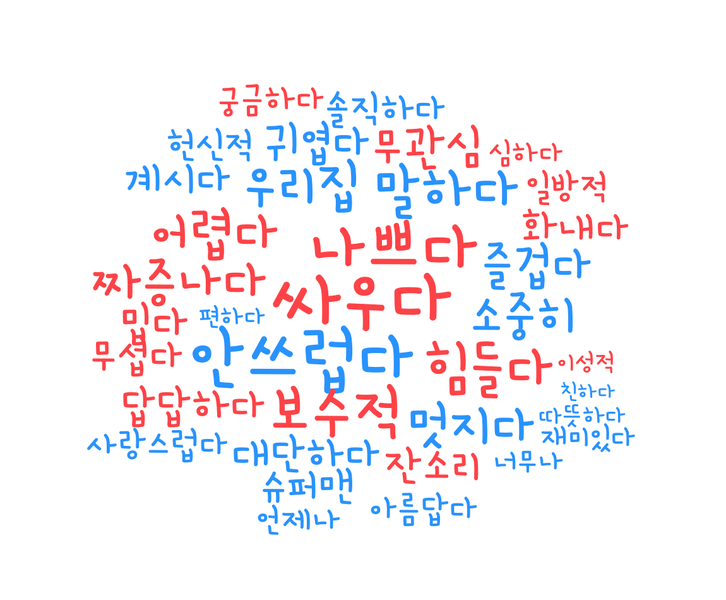

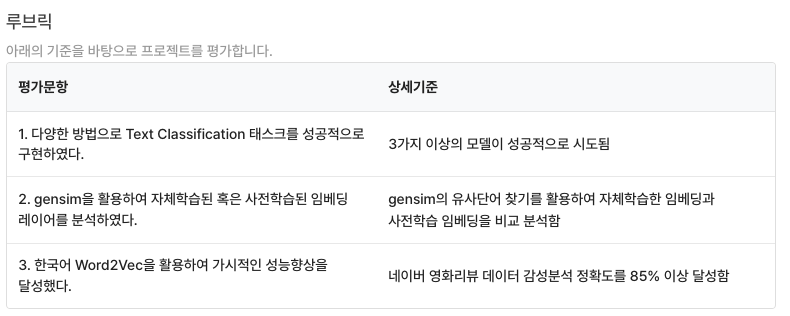

오늘 우리는 딥러닝을 통해 텍스트에 담긴 감성을 분석(Sentimental Analysis)하는 방법을 배워 볼 것입니다. 구체적으로는 IMDb나 네이버 영화 리뷰 텍스트에 담긴 이용자의 감성이 긍정적인지 혹은 부정적인지를 분류(Classification) 할 수 있는 딥러닝 모델을 만들어 볼 것입니다.

## 1) 데이터 준비와 확인

In [1]:
path = '../data/sentiment_analysis'

In [117]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table(path +'/ratings_train.txt')
test_data = pd.read_table(path + '/ratings_test.txt')

train = train_data.copy()
test = test_data.copy()
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### 2.1 데이터 확인

In [118]:
#check data info
train.info() #5개 결측치가 document 컬럼에 보입니다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [119]:
test.info() #test에도 결측치가 발견되었습니다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


### 2.2 결측치 제거

In [120]:
#결측치 확인
train[train['document'].isna()==True] #이 데이터들은 사용할 수 없겠네요~

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [121]:
#결측치 삭제
for i in [train,test]:
    i.dropna(inplace=True)

In [122]:
print(train_data.shape, test_data.shape)
print(train.shape,test.shape) #삭제 된 것을 확인

(150000, 3) (50000, 3)
(149995, 3) (49997, 3)


### 2.3 중복 제거

In [123]:
#check duplicated 
print(train.duplicated(subset='document').sum()) #train에 3813중복 데이터 발견
train.loc[train.duplicated(subset='document') == True] 

3813


,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149919,6502490,짱,1
149949,3924716,OO 영화,0
149960,6368431,지루하다,0
149966,6735753,1,0


In [124]:
print(test.duplicated(subset='document').sum()) #test에도 840개 발견

840


In [125]:
#중복 제거

for dataset in [train, test] :
    dataset.drop_duplicates(subset='document', inplace=True)

In [126]:
print(train_data.shape, test_data.shape)
print(train.shape,test.shape) #삭제 된 것을 확인

(150000, 3) (50000, 3)
(146182, 3) (49157, 3)


### 2.4 tokenizing & stop words 제거

In [127]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()#메캡을 이용해서 단어 분리
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

sentences = train['document'].tolist() + test['document'].values.tolist()  #train and test 문장들 하나의 리스트로 합성
word_set = set([])

for sentence in sentences :
    a = tokenizer.morphs(sentence) #단어 쪼개기
    a =[word for word in a if not word in stopwords] # 불용어 삭제
    word_set |= set(a) #중복 단어는 set으로 관리
index_to_word = {i+4:word for i, word in enumerate(word_set)} # index to word 생성

In [19]:
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[4]='<UNUSED>'  # 사전에 없는(Unknown) 단어

In [191]:
word_set |= set(['<PAD>' ,'<BOS>', '<UNK>','<UNUSED>'])

### 2.5 사전word_to_index 구성

In [20]:
word_to_index={word:index for index, word in index_to_word.items()}

In [128]:
sentences = train['document'].values # train data into 

### 2.6 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [129]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 2.7 X_train, y_train, X_test, y_test, word_to_index 리턴

In [131]:
#토큰화 작업, 불용어 제거, 문장 합치기
def remove_token(x) :
    sentences_clean = []
    for sentence in x:
        a = tokenizer.morphs(sentence)
        a = [word for word in a if word not in stopwords]
        sentences_clean.append(' '.join(a))
    
    return sentences_clean

In [135]:
sentences_train = train['document'].values
sentences_test = test['document'].values 

X_train = get_encoded_sentences(remove_token(sentences_train), word_to_index)
y_train = train['label'].values 
X_test = get_encoded_sentences(remove_token(sentences_test), word_to_index)
y_test = test['label'].values

In [136]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

146182 146182
49157 49157


In [139]:
# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공

In [27]:
import numpy as np
import tensorflow as tf
import os

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

- pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
- 문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다

In [137]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  16.969376315021577
문장길이 최대 :  117
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [167]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 42)


## 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 4. 0 RNN: Baseline Model

In [247]:
vocab_size =  len(word_set) # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [235]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
modelb = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(8),   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'), # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
])

modelb.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 16)          984576    
                                                                 
 lstm_17 (LSTM)              (None, 8)                 800       
                                                                 
 dense_42 (Dense)            (None, 8)                 72        
                                                                 
 dense_43 (Dense)            (None, 1)                 9         
                                                                 
Total params: 985,457
Trainable params: 985,457
Non-trainable params: 0
_________________________________________________________________


### 4.1 RNN : improved

성능 개선을 위해 Mish라는 활성화 함수를 사용하겠습니다. 

In [214]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
import tensorflow as tf

class Mish(Activation):

    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

Mish의 경우 가중치 초기화 방법으로는 He Normal이 제일 성능이 좋은 것 같습니다. 

source :  https://arxiv.org/pdf/1908.08681.pdf 

In [236]:
initializer = tf.keras.initializers.HeNormal(seed=1)

In [274]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(8,activation='Mish',kernel_initializer=initializer),   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
    tf.keras.layers.Dense(8, activation='Mish',kernel_initializer=initializer),
    tf.keras.layers.Dense(1, activation='sigmoid'), # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
])

model1.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, None, 16)          984576    
                                                                 
 lstm_20 (LSTM)              (None, 8)                 800       
                                                                 
 dense_62 (Dense)            (None, 8)                 72        
                                                                 
 dense_63 (Dense)            (None, 1)                 9         
                                                                 
Total params: 985,457
Trainable params: 985,457
Non-trainable params: 0
_________________________________________________________________


### 4.2 Conv : Mish, He initializer

In [252]:
model2 = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
tf.keras.layers.Conv1D(16, 7, activation='Mish',kernel_initializer=initializer),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Conv1D(16, 7, activation='Mish',kernel_initializer=initializer),
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(8, activation='Mish',kernel_initializer=initializer),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, None, 16)          984576    
                                                                 
 conv1d_12 (Conv1D)          (None, None, 16)          1808      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_10 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 8)               

### 4.3 GlobalMaxPooling

In [253]:
model3 = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(8, activation='Mish',kernel_initializer=initializer),
tf.keras.layers.Dense(1, activation='sigmoid')  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 
])

model3.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, None, 16)          984576    
                                                                 
 global_max_pooling1d_11 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_60 (Dense)            (None, 8)                 136       
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 984,721
Trainable params: 984,721
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

- model 훈련 전에, 훈련용 데이터셋 `70%`를 분리하여 검증셋(validation set) `30%`를 사용하도록 합니다.

In [254]:
val_size =int(len(x_train) * 0.3) +1 

In [255]:
# validation set 10000건 분리
x_val = x_train[:val_size]   
y_val = y_train[:val_size]

# validation set을 제외한 나머지 
partial_x_train = x_train[val_size:]  
partial_y_train = y_train[val_size:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(102327, 42)
(102327,)


### 5.0 RNN : Baseline

In [242]:
modelb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history0 = modelb.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 23s 85ms/step - loss: 0.5574 - accuracy: 0.7295 - val_loss: 0.4088 - val_accuracy: 0.8386
Epoch 2/20
200/200 [==============================] - 18s 90ms/step - loss: 0.3490 - accuracy: 0.8594 - val_loss: 0.3531 - val_accuracy: 0.8487
Epoch 3/20
200/200 [==============================] - 17s 87ms/step - loss: 0.2895 - accuracy: 0.8869 - val_loss: 0.3535 - val_accuracy: 0.8497
Epoch 4/20
200/200 [==============================] - 19s 94ms/step - loss: 0.2566 - accuracy: 0.9033 - val_loss: 0.3636 - val_accuracy: 0.8492
Epoch 5/20
200/200 [==============================] - 18s 89ms/step - loss: 0.2342 - accuracy: 0.9130 - val_loss: 0.3764 - val_accuracy: 0.8453
Epoch 6/20
200/200 [==============================] - 17s 87ms/step - loss: 0.2168 - accuracy: 0.9206 - val_loss: 0.4002 - val_accuracy: 0.8419
Epoch 7/20
200/200 [==============================] - 17s 86ms/step - loss: 0.2017 - accuracy: 0.9272 - val_loss: 0.4138 - val_accuracy:

### 5.1 RNN Improved : Adablief, He initializer, Mish activation function

In [243]:
# !pip install  tensorflow_addons

AdaBelief optimizer를 이용해 loss 를 보다 안정적이게 줄여나갈 수 있는 확인해 보겠습니다. 

SOTA 옵티마이저로 ADAM 옵티마이저에 개선 버전이라고 합니다. 

Gradient에 분산을 매 시점마다 기억하고, 분산이 적으면 step을 더 크게 가져가는 특성을 가지고 있습니다. 

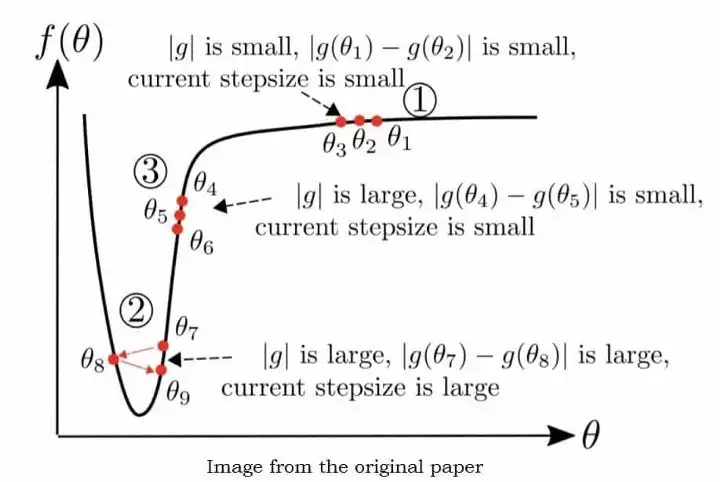

https://medium.com/the-dl/understanding-the-new-adabelief-optimizer-2db70ef6de1e

In [275]:
import tensorflow_addons as tfa
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience = 3) # 훈련 효율성을 감지하면서 개선이 없으면 early stop
learning_rate = 1e-4
model1.compile(optimizer=tfa.optimizers.AdaBelief(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks = [early_stopping],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
200/200 [==============================] - 28s 109ms/step - loss: 0.6930 - accuracy: 0.5381 - val_loss: 0.6926 - val_accuracy: 0.6045
Epoch 2/50
200/200 [==============================] - 22s 108ms/step - loss: 0.6909 - accuracy: 0.6498 - val_loss: 0.6866 - val_accuracy: 0.6860
Epoch 3/50
200/200 [==============================] - 23s 114ms/step - loss: 1.8626 - accuracy: 0.6815 - val_loss: 0.6118 - val_accuracy: 0.7152
Epoch 4/50
200/200 [==============================] - 21s 107ms/step - loss: 1.1316 - accuracy: 0.7381 - val_loss: 0.6775 - val_accuracy: 0.7561
Epoch 5/50
200/200 [==============================] - 21s 107ms/step - loss: 1.3809 - accuracy: 0.7621 - val_loss: 0.7537 - val_accuracy: 0.7707
Epoch 6/50
200/200 [==============================] - 23s 113ms/step - loss: 1.2005 - accuracy: 0.7759 - val_loss: 0.9691 - val_accuracy: 0.7821


### 5.2 Conv : Mish, He initializer

In [257]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3) # 훈련 효율성을 감지하면서 개선이 없으면 early stop
learning_rate = 1e-4

model2.compile(optimizer=tfa.optimizers.AdaBelief(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks = [early_stopping],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
200/200 [==============================] - 16s 67ms/step - loss: 0.6929 - accuracy: 0.5147 - val_loss: 0.6927 - val_accuracy: 0.5273
Epoch 2/50
200/200 [==============================] - 13s 67ms/step - loss: 0.6922 - accuracy: 0.5465 - val_loss: 0.6915 - val_accuracy: 0.5686
Epoch 3/50
200/200 [==============================] - 14s 69ms/step - loss: 0.6890 - accuracy: 0.6007 - val_loss: 0.6837 - val_accuracy: 0.6426
Epoch 4/50
200/200 [==============================] - 12s 61ms/step - loss: 0.6346 - accuracy: 0.6917 - val_loss: 0.5359 - val_accuracy: 0.7526
Epoch 5/50
200/200 [==============================] - 14s 69ms/step - loss: 0.4857 - accuracy: 0.7712 - val_loss: 0.4538 - val_accuracy: 0.7869
Epoch 6/50
200/200 [==============================] - 13s 66ms/step - loss: 0.4408 - accuracy: 0.7950 - val_loss: 0.4301 - val_accuracy: 0.8012
Epoch 7/50
200/200 [==============================] - 13s 64ms/step - loss: 0.4200 - accuracy: 0.8081 - val_loss: 0.4173 - val_accuracy:

In [258]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3) # 훈련 효율성을 감지하면서 개선이 없으면 early stop
learning_rate = 1e-4

model3.compile(optimizer=tfa.optimizers.AdaBelief(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    callbacks = [early_stopping],
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/50
200/200 [==============================] - 7s 24ms/step - loss: 0.6926 - accuracy: 0.5390 - val_loss: 0.6918 - val_accuracy: 0.5882
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 0.6903 - accuracy: 0.6323 - val_loss: 0.6883 - val_accuracy: 0.6667
Epoch 3/50
200/200 [==============================] - 4s 22ms/step - loss: 0.6850 - accuracy: 0.6814 - val_loss: 0.6804 - val_accuracy: 0.7011
Epoch 4/50
200/200 [==============================] - 4s 22ms/step - loss: 0.6717 - accuracy: 0.7228 - val_loss: 0.6591 - val_accuracy: 0.7399
Epoch 5/50
200/200 [==============================] - 5s 23ms/step - loss: 0.6369 - accuracy: 0.7531 - val_loss: 0.6080 - val_accuracy: 0.7674
Epoch 6/50
200/200 [==============================] - 4s 22ms/step - loss: 0.5735 - accuracy: 0.7759 - val_loss: 0.5364 - val_accuracy: 0.7803
Epoch 7/50
200/200 [==============================] - 5s 22ms/step - loss: 0.5096 - accuracy: 0.7866 - val_loss: 0.4833 - val_accuracy: 0.7889

## 6) Loss, Accuracy 그래프 시각화

In [262]:
resultsb = modelb.evaluate(x_test,  y_test, verbose=2)
print(resultsb)

1537/1537 - 10s - loss: 0.6583 - accuracy: 0.8156 - 10s/epoch - 6ms/step
[0.6582598090171814, 0.8155908584594727]


In [276]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)
print(results1)

1537/1537 - 13s - loss: 0.5445 - accuracy: 0.7784 - 13s/epoch - 8ms/step
[0.5444561839103699, 0.7783632278442383]


In [264]:
results2 = model2.evaluate(x_test,  y_test, verbose=2)
print(results2)

1537/1537 - 4s - loss: 0.3870 - accuracy: 0.8289 - 4s/epoch - 3ms/step
[0.3869549334049225, 0.828915536403656]


In [265]:
results3 = model3.evaluate(x_test,  y_test, verbose=2)
print(results3)

1537/1537 - 3s - loss: 0.3710 - accuracy: 0.8357 - 3s/epoch - 2ms/step
[0.37095388770103455, 0.8356897234916687]


In [267]:
history_dictb = history0.history
print(history_dictb.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [277]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

In [278]:
histories = [history_dictb,history_dict1,history_dict2,history_dict3]

### 6.2 시각화

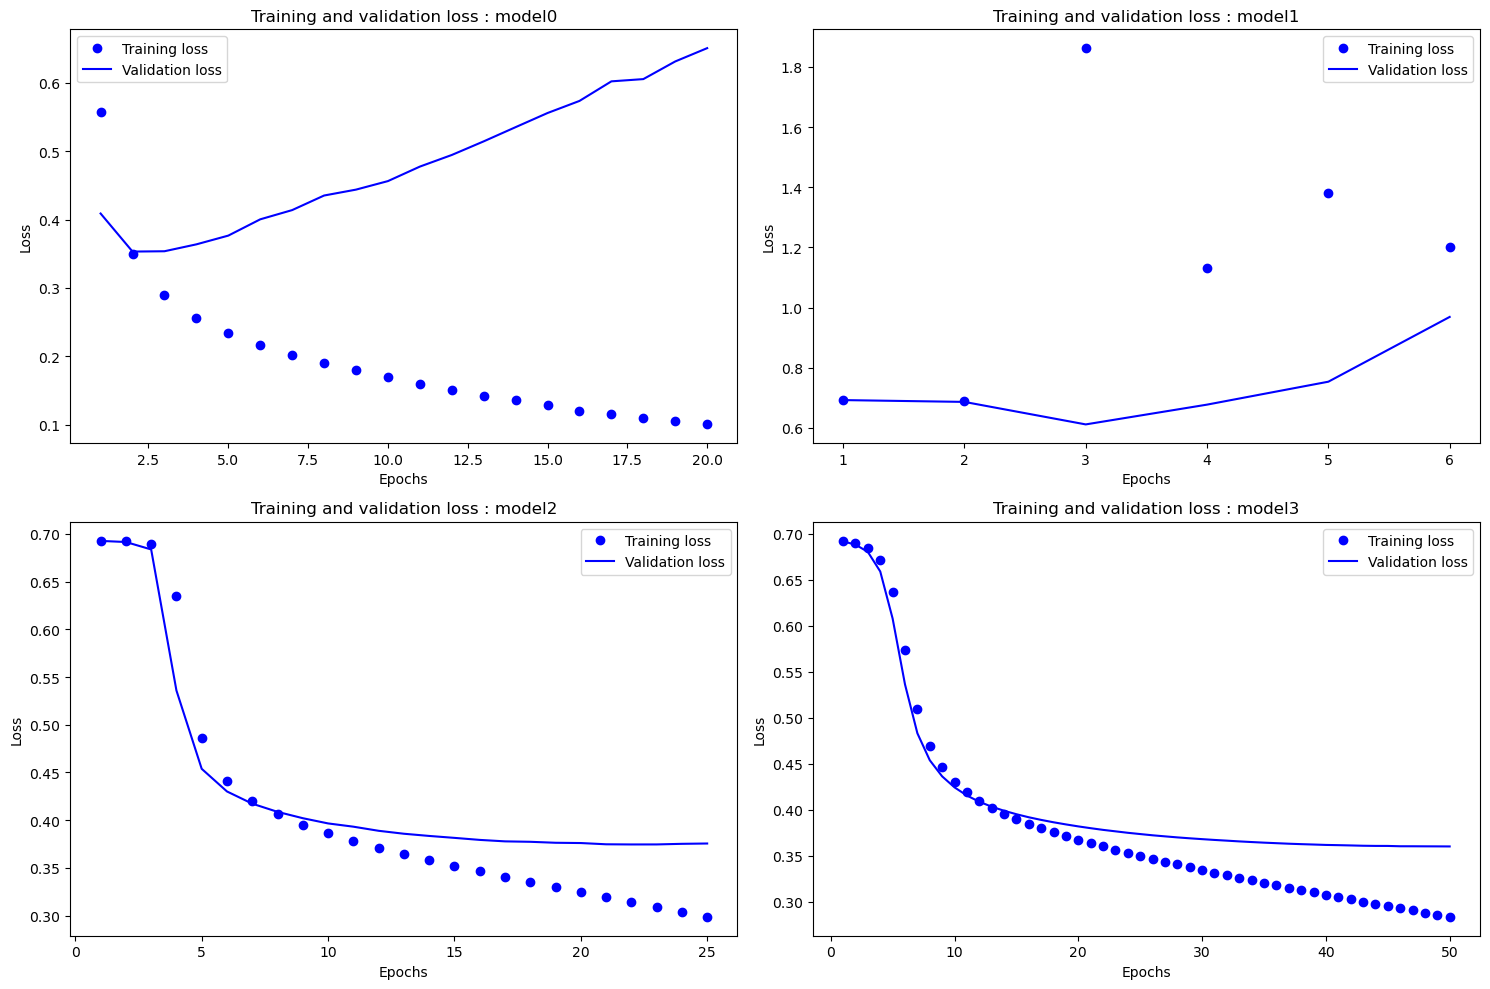

In [279]:
import matplotlib.pyplot as plt

# "bo"는 "파란색 점"입니다
fig =plt.figure(figsize = (15,10))

for i,h in enumerate(histories) :
    acc = h['accuracy']
    val_acc = h['val_accuracy']
    loss = h['loss']
    val_loss = h['val_loss']

    epochs = range(1, len(acc) + 1)
    ax = fig.add_subplot(2,2,i+1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss : model{i}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

Mish activation function과 Adabelief optimizer를 사용한 모델들은 loss 와 val-loss 나란히 줄어드는 것을 보실 수 있습니다. 

optimzer 선택에 따라 모델 성능 향상에 분명히 영향을 미치는 것을 확인했습니다. 

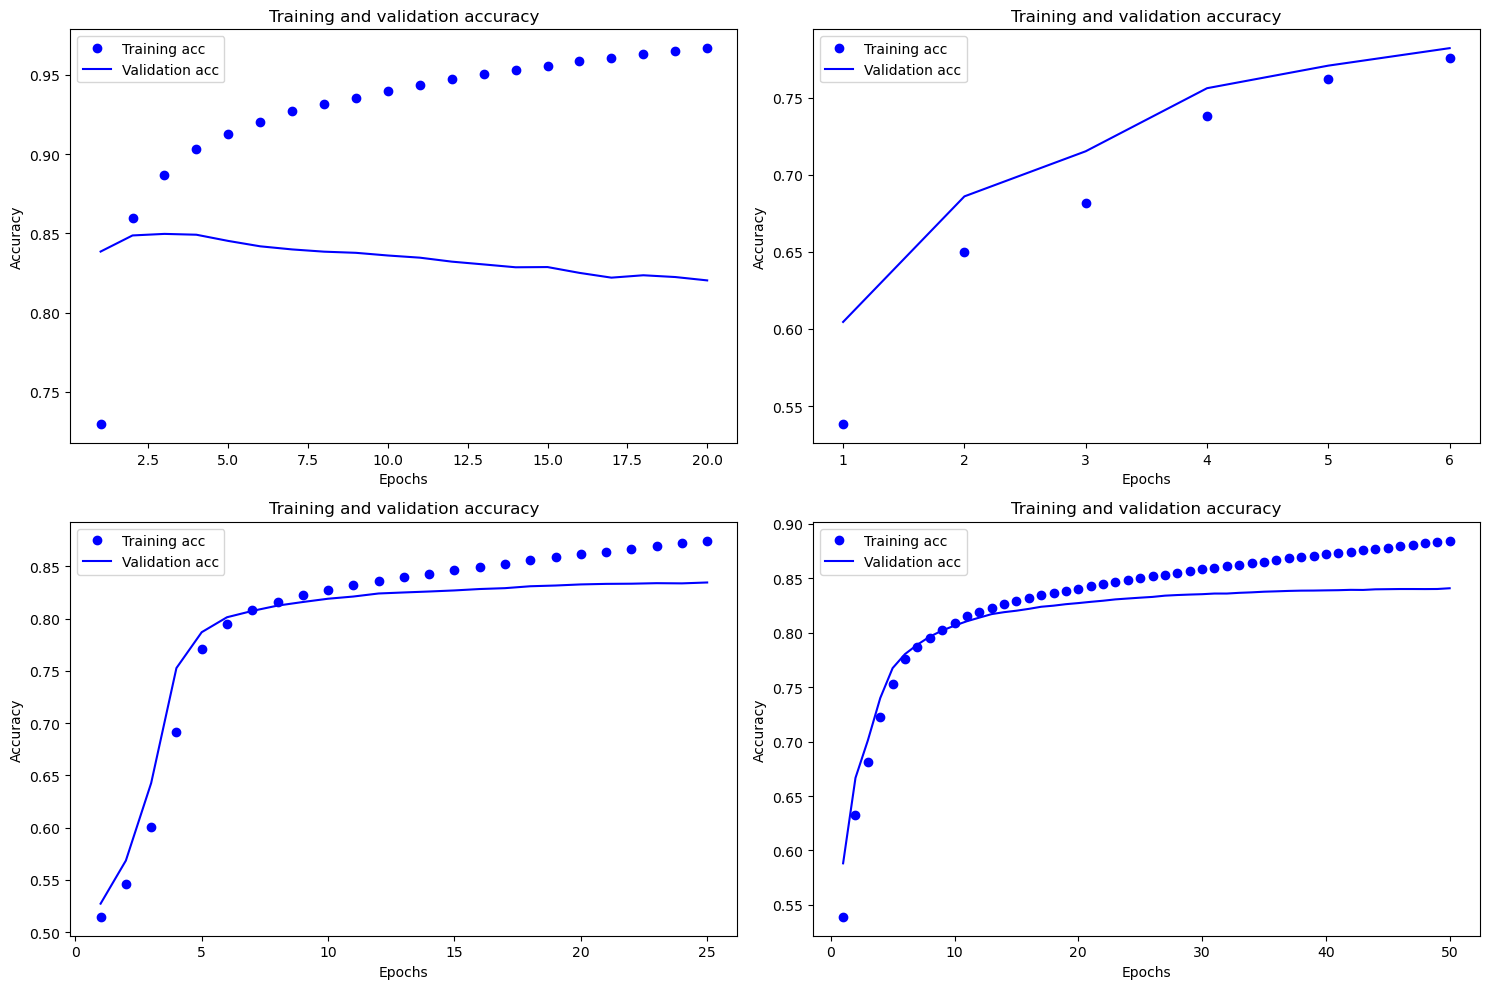

In [280]:
fig =plt.figure(figsize = (15,10))

for i,h in enumerate(histories) :
    acc = h['accuracy']
    val_acc = h['val_accuracy']
    loss = h['loss']
    val_loss = h['val_loss']

    epochs = range(1, len(acc) + 1)
    ax = fig.add_subplot(2,2,i+1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
plt.tight_layout()
plt.show()

정확도 마찬가지로 Adabelief 옵티마이저를 사용했을때 훨씬 좋은 개선도를 보입니다. 

## 7) 학습된 Embedding 레이어 분석

In [289]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [281]:
#embedding 결과 저장
embedding_layerb = modelb.layers[0]
weightsb = embedding_layerb.get_weights()[0]

print(weightsb .shape)    # shape: (vocab_size, embedding_dim)

embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]


print(weights1 .shape)    # shape: (vocab_size, embedding_dim)


embedding_layer2 = model2.layers[0]
weights2 = embedding_layer2.get_weights()[0]


print(weights2 .shape)    # shape: (vocab_size, embedding_dim)

embedding_layer3 = model3.layers[0]
weights3 = embedding_layer3.get_weights()[0]


print(weights3 .shape)    # shape: (vocab_size, embedding_dim)

(61536, 16)


In [295]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
model_dict = {'b' : modelb,'1':model1,'2':model2,'3': model3}

for i,md in model_dict.items() :
    word2vec_file_path = f'../data/sentiment_analysis/word2vec{i}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = md.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [296]:
#임베딩 내용 불러오기
word2vec_file_pathb = '../data/sentiment_analysis/word2vecb.txt'
word2vec_file_path1 = '../data/sentiment_analysis/word2vec1.txt'
word2vec_file_path2 = '../data/sentiment_analysis/word2vec2.txt'
word2vec_file_path3 = '../data/sentiment_analysis/word2vec3.txt'

### baseline model

In [320]:
word_vectorsb = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_pathb, binary=False)
word_vectorsb.similar_by_word("연출")

[('완전', 0.8490144610404968),
 ('신야', 0.8451725840568542),
 ('혹시', 0.8372873663902283),
 ('백업', 0.8249883055686951),
 ('컬럼', 0.7926287651062012),
 ('강유리', 0.791668176651001),
 ('봣으니', 0.7844650149345398),
 ('재미', 0.7828686237335205),
 ('서기', 0.7818427085876465),
 ('여동생', 0.7767829895019531)]

In [319]:
word_vectorsb.similar_by_word("주인공")

[('진지', 0.9021013975143433),
 ('라자드', 0.895702064037323),
 ('달러', 0.8698298931121826),
 ('모니터', 0.8621253967285156),
 ('렵니다', 0.849620521068573),
 ('덧없', 0.8430688381195068),
 ('꺅', 0.8429577946662903),
 ('서커스', 0.8427445888519287),
 ('tthe', 0.8354431986808777),
 ('춥', 0.8353987336158752)]

### RNN improved

In [321]:
word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
word_vectors1.similar_by_word("연출")

[('축구', 0.8673905730247498),
 ('즐겨', 0.819087564945221),
 ('하', 0.8108947277069092),
 ('뿌리친다', 0.7997521162033081),
 ('찰떡궁합', 0.7967919111251831),
 ('직장', 0.793880820274353),
 ('그랴', 0.7880011796951294),
 ('최승희', 0.7856302857398987),
 ('점', 0.7842460870742798),
 ('저의', 0.7814450263977051)]

In [318]:
word_vectors1.similar_by_word("주인공")

[('친하', 0.8441524505615234),
 ('도굴범', 0.8214250802993774),
 ('마쇼', 0.8171340227127075),
 ('.""', 0.8159312009811401),
 ('.\\..', 0.812348484992981),
 ('화', 0.8098152875900269),
 ('걸려버렸', 0.8082650899887085),
 ('다면서요', 0.801171600818634),
 ('럴', 0.7986003756523132),
 ('구디', 0.7870627045631409)]

### Conv model

In [322]:
word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
word_vectors2.similar_by_word("연출")

[('의향', 0.8177096843719482),
 ('두둑', 0.8041843175888062),
 ('추궁', 0.7965940833091736),
 ('병졸', 0.7935992479324341),
 ('~~~^^;;;', 0.7866312861442566),
 ('띠방', 0.7857240438461304),
 ('닉쿤', 0.785653293132782),
 ('들었었는데', 0.785070538520813),
 ('박상호', 0.7791805863380432),
 ('영체', 0.7785407304763794)]

In [317]:
word_vectors2.similar_by_word("주인공")

[('괜찬다', 0.8456778526306152),
 ('씨엔블루', 0.836702823638916),
 ('외진', 0.8204652667045593),
 ('크롤러', 0.8187053799629211),
 ('ㅜ남주', 0.8104144334793091),
 ('클램프', 0.8102229237556458),
 ('망신', 0.7853628396987915),
 ('부질없이', 0.7837883830070496),
 ('객사', 0.7796639204025269),
 ('ㅠㅠ어제보고', 0.7770534753799438)]

### Global Max Pooling model

In [323]:
word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, binary=False)
word_vectors3.similar_by_word("연출")

[('휴댄시', 0.8734542727470398),
 ('다운로드', 0.8602762222290039),
 ('등산객', 0.8494236469268799),
 ('무지무지', 0.8429506421089172),
 ('다', 0.840937077999115),
 ('미련없이', 0.8400904536247253),
 ('걸레짝', 0.8389191627502441),
 ('가도', 0.8386468291282654),
 ('오션스', 0.8273342847824097),
 ('함', 0.8251460790634155)]

In [316]:
word_vectors3.similar_by_word("주인공")

[('crist', 0.9072232246398926),
 ('진심', 0.89635169506073),
 ('찰리채플린', 0.8871312141418457),
 ('제목', 0.8800397515296936),
 ('엄청날', 0.8716237545013428),
 ('라는', 0.8484770059585571),
 ('..', 0.8469215631484985),
 ('개탄', 0.8326836228370667),
 ('것', 0.8251196146011353),
 ('~~', 0.8229604959487915)]

제가 영화를 별로 안봐서 어떤 키워드를 사용해야할지 잘 모르겠습니다.

다만 연관어들이 조금 어색하고, 토크나이징이 조금 더 개선이 필요할 것 같습니다. 

동사, 명사, 형용사 등 조금 더 구분을 더 짓고 깨끗한 데이터로 분석이 필요할 것 같네요. 

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models

https://radimrehurek.com/gensim/models/keyedvectors.html

In [382]:
model_filepath = '../data/sentiment_analysis/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(model_filepath)

In [343]:
word2vec.wv.vectors.shape

(302960, 100)

In [344]:
print(word2vec.wv.most_similar("주인공"))

[('여주인공', 0.8585050106048584), ('악당', 0.7656230330467224), ('악역', 0.7371293902397156), ('원작', 0.7292890548706055), ('상대역', 0.7271792888641357), ('등장인물', 0.7155714631080627), ('애완견', 0.690655529499054), ('미소년', 0.6904507875442505), ('악녀', 0.6724177598953247), ('캐릭터', 0.6683714985847473)]


In [361]:
len(word2vec.wv['주인공'])

100

In [352]:
index_to_word[5]

'스티스'

In [359]:
word2vec.wv

In [362]:
embedding_matrix = np.random.rand(vocab_size, 100)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [376]:
from tensorflow.keras.initializers import Constant

# 모델 구성
modelf = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 
                                 100, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True),   # trainable을 True로 주면 Fine-tuning
    tf.keras.layers.Conv1D(16, 7, activation='Mish',kernel_initializer=initializer),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(16, 7, activation='Mish',kernel_initializer=initializer),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='Mish',kernel_initializer=initializer),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])

modelf.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 42, 100)           6153600   
                                                                 
 conv1d_22 (Conv1D)          (None, 36, 16)            11216     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 7, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_16 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_72 (Dense)            (None, 8)               

In [377]:
# 학습의 진행
modelf.compile(optimizer=tfa.optimizers.AdaBelief(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

historyf = modelf.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    callbacks=[early_stopping],
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/100
200/200 [==============================] - 53s 243ms/step - loss: 1.0516 - accuracy: 0.4890 - val_loss: 0.7379 - val_accuracy: 0.4896
Epoch 2/100
200/200 [==============================] - 46s 230ms/step - loss: 0.7206 - accuracy: 0.5013 - val_loss: 0.7131 - val_accuracy: 0.5025
Epoch 3/100
200/200 [==============================] - 47s 237ms/step - loss: 0.7063 - accuracy: 0.5132 - val_loss: 0.7032 - val_accuracy: 0.5128
Epoch 4/100
200/200 [==============================] - 47s 235ms/step - loss: 0.6972 - accuracy: 0.5263 - val_loss: 0.6951 - val_accuracy: 0.5293
Epoch 5/100
200/200 [==============================] - 47s 233ms/step - loss: 0.6881 - accuracy: 0.5481 - val_loss: 0.6846 - val_accuracy: 0.5600
Epoch 6/100
200/200 [==============================] - 47s 237ms/step - loss: 0.6739 - accuracy: 0.5803 - val_loss: 0.6667 - val_accuracy: 0.5940
Epoch 7/100
200/200 [==============================] - 46s 232ms/step - loss: 0.6509 - accuracy: 0.6201 - val_loss: 0.6412 -

In [378]:
resultsf = modelf.evaluate(x_test,  y_test, verbose=2)

print(resultsf)

1537/1537 - 6s - loss: 0.4499 - accuracy: 0.7965 - 6s/epoch - 4ms/step
[0.4498853385448456, 0.7965294718742371]


In [379]:
history_dictf = historyf.history

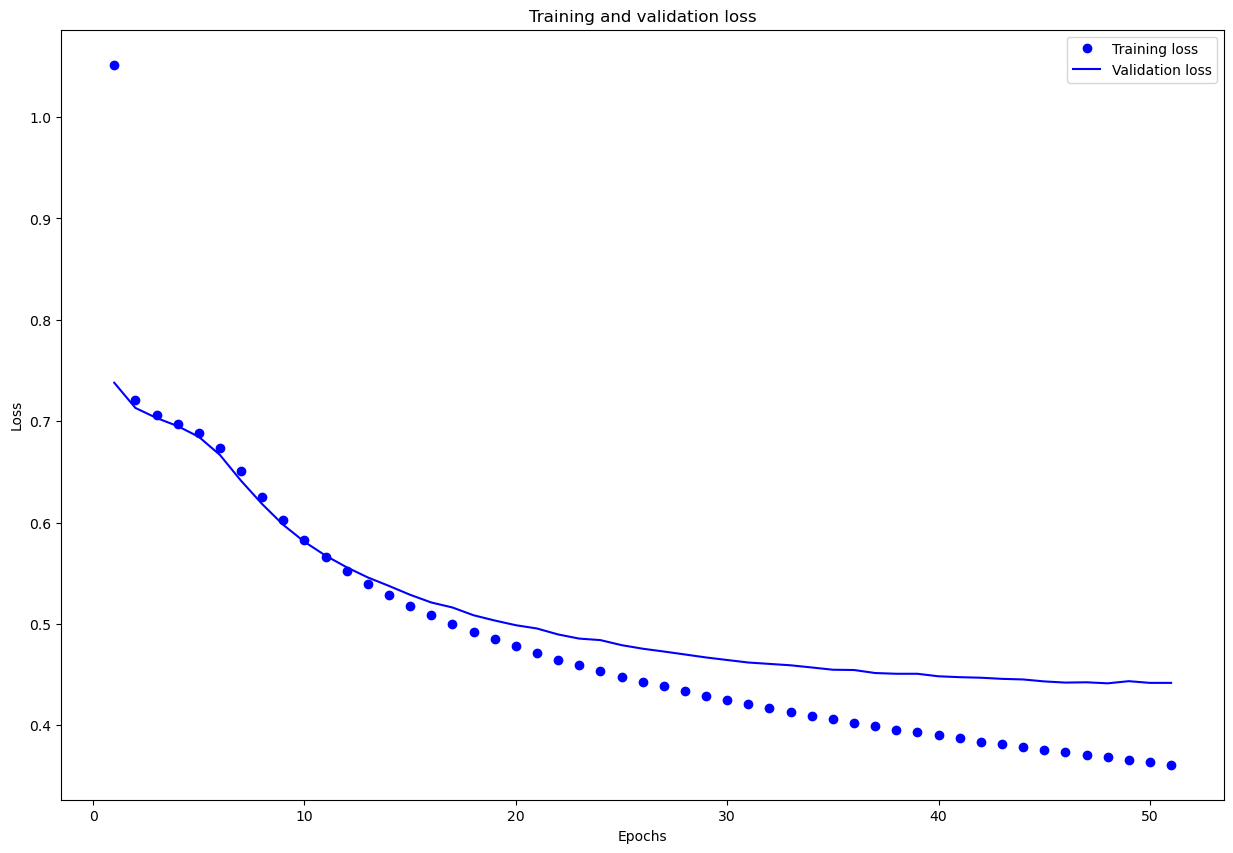

In [380]:
import matplotlib.pyplot as plt

# "bo"는 "파란색 점"입니다
fig =plt.figure(figsize = (15,10))

acc = history_dictf['accuracy']
val_acc = history_dictf['val_accuracy']
loss = history_dictf['loss']
val_loss = history_dictf['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

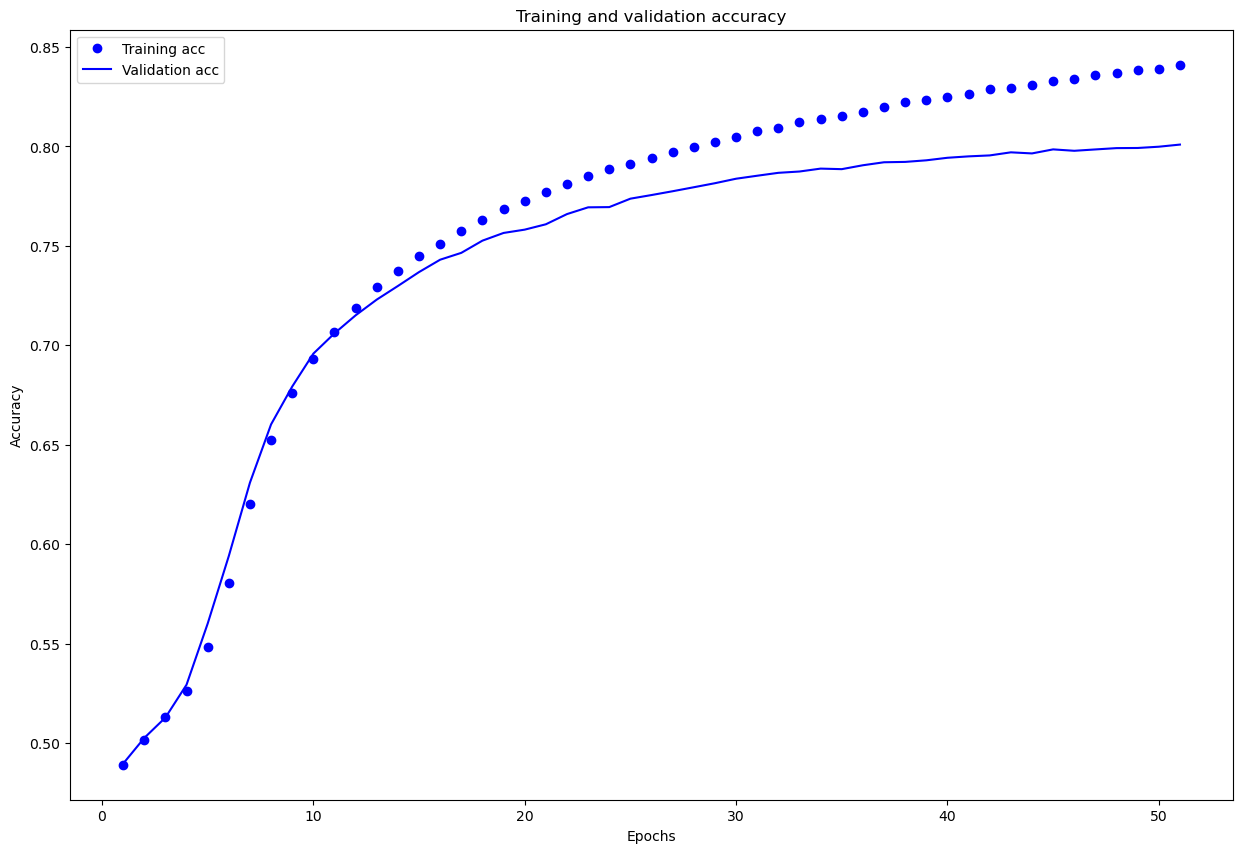

In [381]:
fig =plt.figure(figsize = (15,10))

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [387]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 

word2vec_file_path = f'../data/sentiment_analysis/word2vecf.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, 100))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = modelf.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [395]:
word_vectorsf = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectorsf.similar_by_word("연출")

[('연기', 0.7554746866226196),
 ('각색', 0.7388132810592651),
 ('패러디', 0.6663563251495361),
 ('각본', 0.6642361879348755),
 ('출연', 0.6475306749343872),
 ('촬영', 0.6388484239578247),
 ('극본', 0.6387255787849426),
 ('열연', 0.637126088142395),
 ('재연', 0.6311119794845581),
 ('감상', 0.6298357248306274)]

In [390]:
word_vectorsf.similar_by_word("주인공")

[('여주인공', 0.860791802406311),
 ('악당', 0.7637911438941956),
 ('악역', 0.7360268831253052),
 ('원작', 0.7290324568748474),
 ('상대역', 0.7248762845993042),
 ('등장인물', 0.7172568440437317),
 ('애완견', 0.6879459619522095),
 ('미소년', 0.6808509230613708),
 ('캐릭터', 0.6737725734710693),
 ('악녀', 0.6716845631599426)]

이미 학습된 모델을 사용해서 보다 자연스러운 연관어들이 추출이 되네요.

모델 성능을 보다 더 향상 시킬 필요는 있어보입니다. 

이번 프로젝트에서는 여기까지만 진행하겠습니다. 

## 회고

이번 프로젝트 통해서 NLP에 대한 관심이 조금 더 생긴것 같아서 좋았다. 

임베딩을 통해 자연어의 segmentation gap을 조금 더 좁혀서 다양한 방법으로 분석을 할 수 있는 것을 배웄다.

단어들간에 긍부정 외에도 다양한 단어들 간에 연관성을 찾아서 특정 단어와 연관된 주요 단어들을 추출할 수 있을 것 같다.

제가 영화나, 리뷰 분석에 크게 관심을 갖지 않고 있어서 정말 최소한에 모델링만 하고 끝냈다.

보다 괌심을 갖고 다양한 방식에 시각화와, 모델링 개선, 그리고 시사점을 뽑아 내는 것까지도 추후에 해볼 필요가 있을 것 같다. 

오늘은 여기까지만 작성해보겠습니다. 